# Ultrasound Nerve Segmentation
## Identify nerve structures in ultrasound images of the neck

The dataset is from a popular Kaggle competition: 
https://www.kaggle.com/c/ultrasound-nerve-segmentation/

To build my CNN I am using recomentations form notes for the Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition. 

http://cs231n.github.io/convolutional-networks/

I am using the Dice score as the preformance evaluating mentrics:
http://cs231n.stanford.edu/reports/2017/pdfs/526.pdf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#from os import listdir
#from os.path import isfile, isdir, join, splitext
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from PIL import Image
#from skimage.transform import rescale, resize, downscale_local_mean
#from skimage import data, color

In [3]:
train = pd.read_csv("tr_data.csv")
n_train = train.shape[0]

test = pd.read_csv("test_data.csv")
n_test = test.shape[0]

In [3]:
train.head(3)

,image,mask
0,2_88.tif,2_88_mask.tif
1,4_67.tif,4_67_mask.tif
2,5_62.tif,5_62_mask.tif


In [4]:
test.tail()

,image,mask
94,1_36.tif,1_36_mask.tif
95,3_72.tif,3_72_mask.tif
96,1_90.tif,1_90_mask.tif
97,5_6.tif,5_6_mask.tif
98,2_64.tif,2_64_mask.tif


In [5]:
ims_train = []
for i in train['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ims_train.append(a)
ims_train = np.array(ims_train)
ims_train = ims_train.reshape(-1, 32,32, 1)
ims_train = ims_train/255
ims_train = np.array( ims_train, dtype=np.float32 ) 

In [6]:
ims_train.shape

(500, 32, 32, 1)

In [7]:
ms_train = []
for i in train['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ms_train.append(a)
ms_train = np.array(ms_train)
ms_train = ms_train.reshape(-1, 32,32, 1)
ms_train = ms_train/255
ms_train = np.array(ms_train, dtype=np.float32 ) 

In [8]:
ms_train.shape

(500, 32, 32, 1)

In [9]:
ims_test = []
for i in test['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ims_test.append(a)
ims_test = np.array(ims_test)
ims_test = ims_test.reshape(-1, 32,32,1)
ims_test = ims_test/255
ims_test = np.array( ims_test, dtype=np.float32 ) 
ims_test.shape

(99, 32, 32, 1)

In [10]:
ms_test = []
for i in test['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((32,32))
    a=np.array(a)
    ms_test.append(a)
ms_test = np.array(ms_test)
ms_test = ms_test.reshape(-1, 32,32,1)
ms_test = ms_test/255
ms_test = np.array(ms_test, dtype=np.float32 ) 
ms_test.shape

(99, 32, 32, 1)

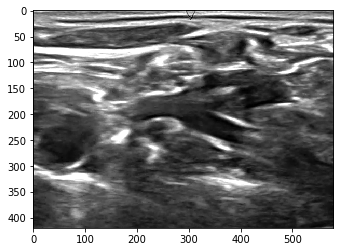

In [11]:
img = Image.open('train_subset/1_106.tif')
plt.imshow(img, cmap='gist_gray')

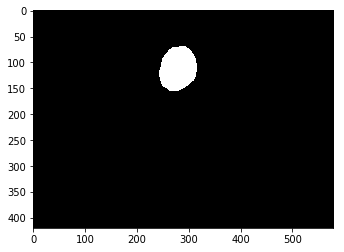

In [12]:
img = Image.open('train_subset/1_106_mask.tif')
plt.imshow(img, cmap='gist_gray')

The **input layer** (that contains the image) should be divisible by 2 many times. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.
My input is (32 * 32 * 1)

In [13]:
x = tf.placeholder(tf.float32,shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

In [4]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

In [5]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def shufled(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Next three function were taken form https://github.com/kkweon/UNet-in-Tensorflow/blob/master/train.py

In [6]:
def upsampling_2D(tensor,  size=(2, 2)):
    """Upsample/Rescale `tensor` by size
    Args:
        tensor (4-D Tensor): (N, H, W, C)
        name (str): name of upsampling operations
        size (tuple, optional): (height_multiplier, width_multiplier)
            (default: (2, 2))
    Returns:
        output (4-D Tensor): (N, h_multiplier * H, w_multiplier * W, C)
    """
    H, W, _ = tensor.get_shape().as_list()[1:]

    H_multi, W_multi = size
    target_H = H * H_multi
    target_W = W * W_multi

    return tf.image.resize_nearest_neighbor(tensor, (target_H, target_W))

In [7]:
def upsample_concat(inputA, input_B):
    """Upsample `inputA` and concat with `input_B`
    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation
    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    upsample = upsampling_2D(inputA, size=(2, 2))

    return tf.concat([upsample, input_B], axis=-1)

In [8]:
# taken form  https://github.com/kkweon/UNet-in-Tensorflow/blob/master/train.py 
# but I renabed it from UIO_ into "dice_score" since 
# it return the value 2 * area of overlap / (area of overlap + area of union)
# but IOU is area of overlap / area of union
# IoU metric tends to penalize single instances of bad classification more than the dice score
def dice_score(y_pred, y_true): # same as F1 score
    """Returns a dice score
    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7
    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)
    Returns:
        float: IOU score
    """
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)

# The First Basic CNN:
I am using resized images (32 by 32 by 1) and a very simple cnn:
* convolution layer with kernel 3 by 3 and 32 filters
* max pool 2 by 2
* convolution layer with kernel 3 by 3 and 64 filters
* upsampling using tf.image.resize_nearest_neighbor 
* convolution layer with kernel 3 by 3 and 32 filters
* the very last layer is a convolution layer with 1 filter and kernel 1 by 1 that help me to get 2D prediction (our mask is black and withe)

### Create the Layers

The **conv layers** should be using small filters (e.g. 3x3 or at most 5x5), using a stride of 1, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. 

Stride of 1 works better in practice. Additionally, stride 1 allows us to leave all spatial down-sampling to the POOL layers, with the CONV layers only transforming the input volume depth-wise.

The **pool layers** are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with 2x2 receptive fields and with a stride of 2. 

In [19]:
convo_1 = convolutional_layer(x,shape=[3,3,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [20]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,32,64]) # images 16*16
#convo_2_pooling = max_pool_2by2(convo_2)

In [21]:
up_1 = upsample_concat(convo_2, convo_1) # image 32*32
convo_3 = convolutional_layer(up_1,shape=[3,3,96,32])

In [22]:
# training prediction
pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

In [23]:
loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.001)
train = optim.minimize(loss)

In [24]:
init = tf.global_variables_initializer()

In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(1500):
        #offset = (i * 100) % (ims_train.shape[0] - 100) # 100 is the batch size
        #batch_x = ims_train[offset:(offset + 100), :]
        #batch_y = ms_train[offset:(offset + 100), :]
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test})
#final_train_loss = sess.run(loss, feed_dict={x:ims_train,y:ms_train,hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
#print('Final train loss: ', final_train_loss)
print('Final test loss: ', final_test_loss)

Minibatch loss at step 0: -0.019102
Currently on step 0
Test loss:
-0.0146958


Minibatch loss at step 50: -0.120964
Currently on step 50
Test loss:
-0.0743517


Minibatch loss at step 100: -0.142987
Currently on step 100
Test loss:
-0.0884497


Minibatch loss at step 150: -0.084245
Currently on step 150
Test loss:
-0.0974051


Minibatch loss at step 200: -0.114185
Currently on step 200
Test loss:
-0.0963559


Minibatch loss at step 250: -0.188440
Currently on step 250
Test loss:
-0.106781


Minibatch loss at step 300: -0.095861
Currently on step 300
Test loss:
-0.0901538


Minibatch loss at step 350: -0.162605
Currently on step 350
Test loss:
-0.10909


Minibatch loss at step 400: -0.158555
Currently on step 400
Test loss:
-0.112519


Minibatch loss at step 450: -0.116581
Currently on step 450
Test loss:
-0.113564


Minibatch loss at step 500: -0.208191
Currently on step 500
Test loss:
-0.110966


Minibatch loss at step 550: -0.233744
Currently on step 550
Test loss:
-0.102698


Minib

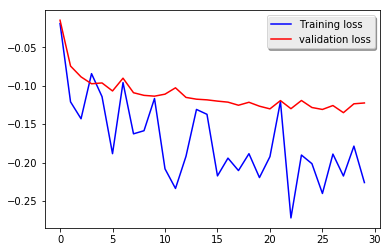

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [27]:
test_result = output >= 0.5

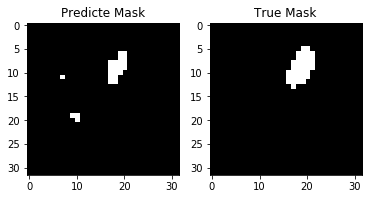

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(test_result[3].reshape(32, 32),cmap='gist_gray')
axes[0].set_title('Predicte Mask')

axes[1].imshow(ms_test[3].reshape(32, 32),cmap='gist_gray')
axes[1].set_title('True Mask')

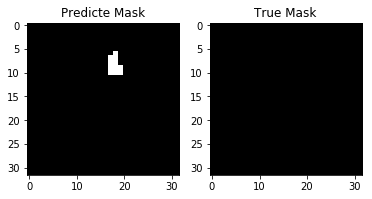

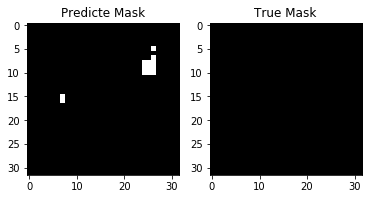

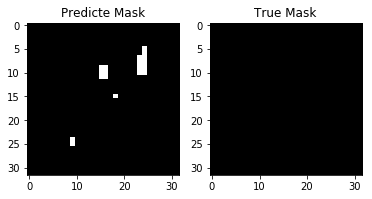

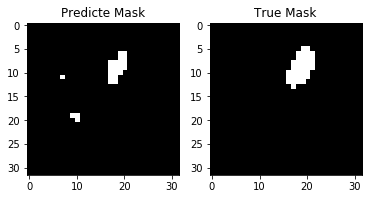

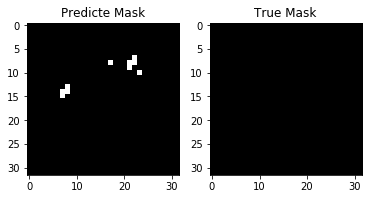

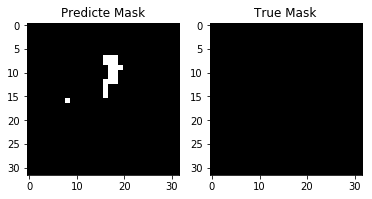

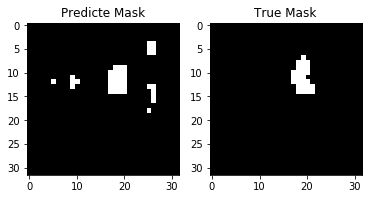

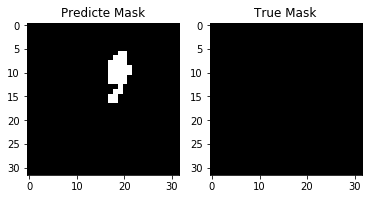

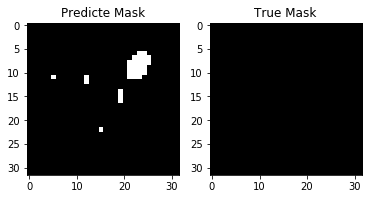

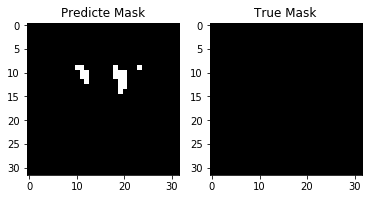

In [29]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(32, 32),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(32, 32),cmap='gist_gray')
    axes[1].set_title('True Mask')

# CNN With Two More Convolution Layers 
I added two more convolutional layers, but decreased the numbers of filters. 
I am using resized images (32 by 32 by 1)
* **2** convolution layer with kernel 3 by 3 and 16 filters
* max pool 2 by 2
* convolution layer with kernel 3 by 3 and 32 filters
* upsampling using tf.image.resize_nearest_neighbor 
* **2** convolution layer with kernel 3 by 3 and 16 filters
* the very last layer is a convolution layer with 1 filter and kernel 1 by 1 that help me to get 2D prediction (our mask is black and withe)

In [30]:
x = tf.placeholder(tf.float32,shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

convo_1 = convolutional_layer(x,shape=[3,3,1,16])
convo_1_2 = convolutional_layer(convo_1,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,16,32]) # images 16*16

up_1 = upsample_concat(convo_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
convo_3 = convolutional_layer(convo_3_0,shape=[3,3,16,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.001)
train = optim.minimize(loss)

In [31]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(1500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test})
#final_train_loss = sess.run(loss, feed_dict={x:ims_train,y:ms_train,hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
#print('Final train loss: ', final_train_loss)
print('Final test loss: ', final_test_loss)

Minibatch loss at step 0: -0.014876
Currently on step 0
Test loss:
-0.0135318


Minibatch loss at step 50: -0.075746
Currently on step 50
Test loss:
-0.0589718


Minibatch loss at step 100: -0.089341
Currently on step 100
Test loss:
-0.0910008


Minibatch loss at step 150: -0.113012
Currently on step 150
Test loss:
-0.092086


Minibatch loss at step 200: -0.090724
Currently on step 200
Test loss:
-0.0988504


Minibatch loss at step 250: -0.181185
Currently on step 250
Test loss:
-0.109237


Minibatch loss at step 300: -0.171855
Currently on step 300
Test loss:
-0.0981104


Minibatch loss at step 350: -0.142751
Currently on step 350
Test loss:
-0.108713


Minibatch loss at step 400: -0.160324
Currently on step 400
Test loss:
-0.120848


Minibatch loss at step 450: -0.201572
Currently on step 450
Test loss:
-0.106816


Minibatch loss at step 500: -0.170979
Currently on step 500
Test loss:
-0.121982


Minibatch loss at step 550: -0.225066
Currently on step 550
Test loss:
-0.126006


Minib

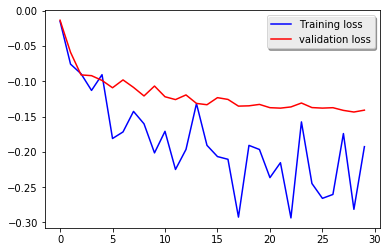

In [32]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

It looks like we have some overfiting. We can try to use "dropout"

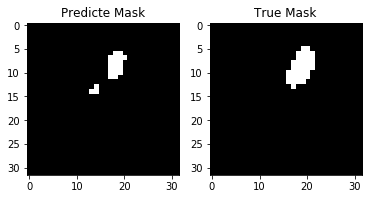

In [33]:
test_result = output >= 0.5

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(test_result[3].reshape(32, 32),cmap='gist_gray')
axes[0].set_title('Predicte Mask')

axes[1].imshow(ms_test[3].reshape(32, 32),cmap='gist_gray')
axes[1].set_title('True Mask')

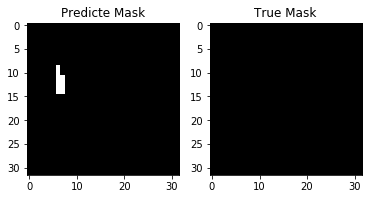

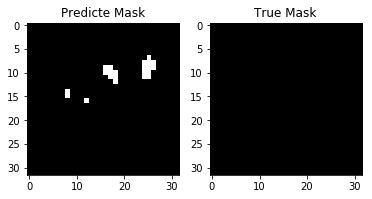

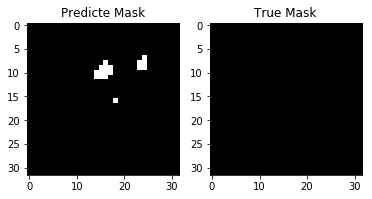

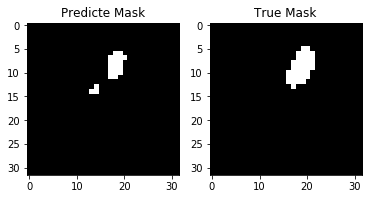

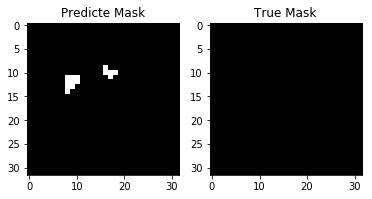

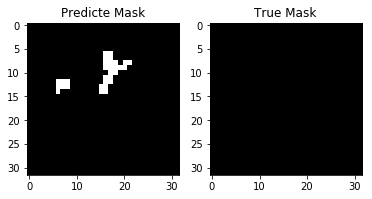

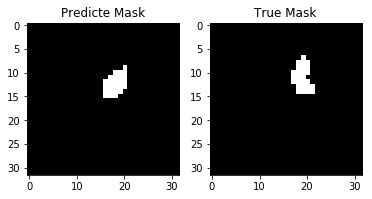

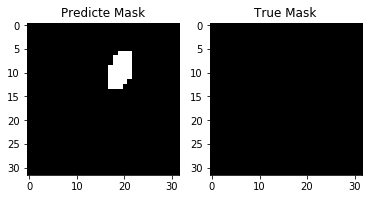

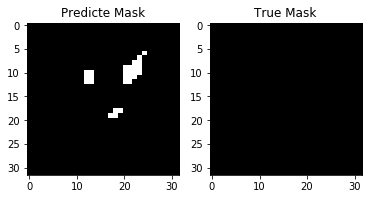

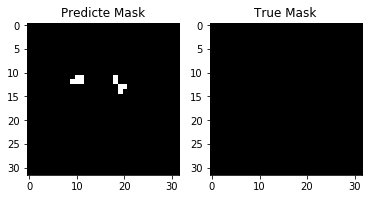

In [34]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(32, 32),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(32, 32),cmap='gist_gray')
    axes[1].set_title('True Mask')

# Add Dropout to prevent overfitting

In [35]:
hold_prob = tf.placeholder(tf.float32)

In [37]:
x = tf.placeholder(tf.float32,shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None, 32,32, 1])

convo_1 = convolutional_layer(x,shape=[3,3,1,16])
dropout_0 = tf.nn.dropout(convo_1,keep_prob=hold_prob)
convo_1_2 = convolutional_layer(dropout_0,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

dropout_1 = tf.nn.dropout(convo_1_pooling,keep_prob=hold_prob)

convo_2 = convolutional_layer(dropout_1,shape=[3,3,16,32]) # images 16*16

dropout_2 = tf.nn.dropout(convo_2,keep_prob=hold_prob)

up_1 = upsample_concat(dropout_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
dropout_3 = tf.nn.dropout(convo_3_0,keep_prob=hold_prob)
convo_3 = convolutional_layer(dropout_3,shape=[3,3,16,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optim.minimize(loss)

In [38]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(2500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y, hold_prob:0.7})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test, hold_prob:1.0})
#final_train_loss = sess.run(loss, feed_dict={x:ims_train,y:ms_train,hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
#print('Final train loss: ', final_train_loss)
print('Final test loss: ', final_test_loss)

Minibatch loss at step 0: -0.012010
Currently on step 0
Test loss:
-0.0134888


Minibatch loss at step 50: -0.018915
Currently on step 50
Test loss:
-0.0242187


Minibatch loss at step 100: -0.042511
Currently on step 100
Test loss:
-0.0366752


Minibatch loss at step 150: -0.047225
Currently on step 150
Test loss:
-0.0395281


Minibatch loss at step 200: -0.052195
Currently on step 200
Test loss:
-0.054566


Minibatch loss at step 250: -0.070060
Currently on step 250
Test loss:
-0.0727609


Minibatch loss at step 300: -0.071400
Currently on step 300
Test loss:
-0.0736582


Minibatch loss at step 350: -0.087507
Currently on step 350
Test loss:
-0.0878763


Minibatch loss at step 400: -0.085517
Currently on step 400
Test loss:
-0.094741


Minibatch loss at step 450: -0.103551
Currently on step 450
Test loss:
-0.0998541


Minibatch loss at step 500: -0.111178
Currently on step 500
Test loss:
-0.101398


Minibatch loss at step 550: -0.146795
Currently on step 550
Test loss:
-0.104866


Mi

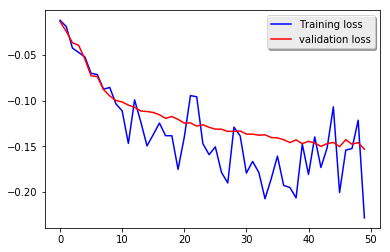

In [39]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

This model works better - we got a bette loss and no oferfitting. 

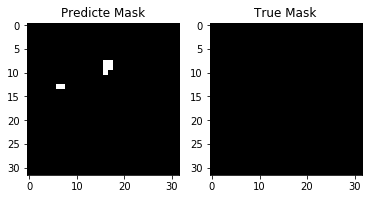

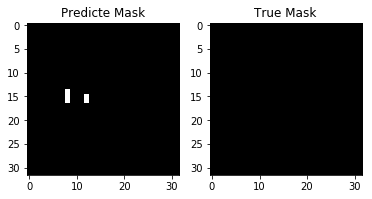

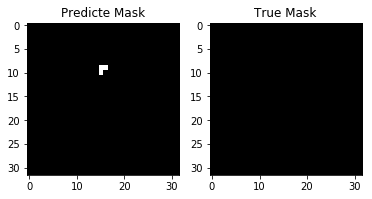

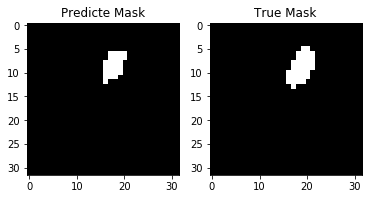

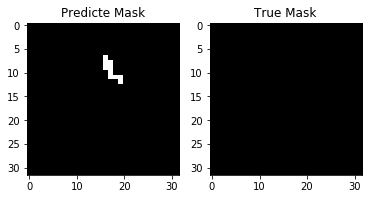

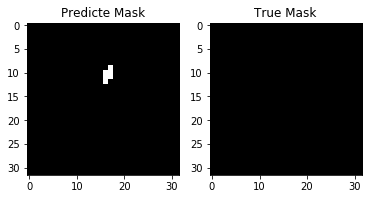

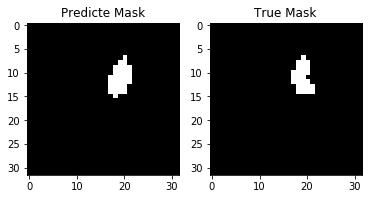

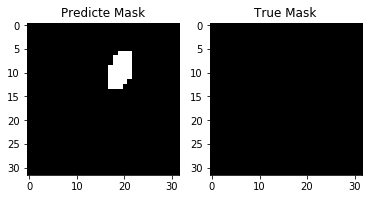

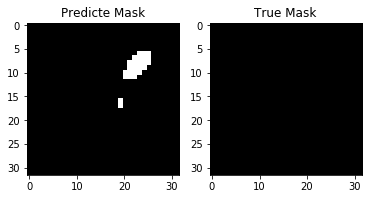

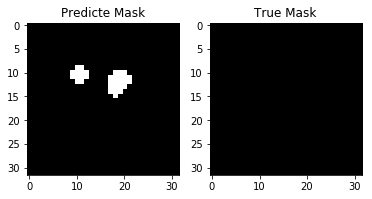

In [41]:
test_result = output >= 0.5  # predicted masks

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(32, 32),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(32, 32),cmap='gist_gray')
    axes[1].set_title('True Mask')

# Now I am going to try use a better resolution for images and add two more pooling layers. 

In [9]:
train = pd.read_csv("tr_data.csv")
n_train = train.shape[0]

test = pd.read_csv("test_data.csv")
n_test = test.shape[0]

ims_train = []
for i in train['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ims_train.append(a)
ims_train = np.array(ims_train)
ims_train = ims_train.reshape(-1, 64,64, 1)
ims_train = ims_train/255
ims_train = np.array( ims_train, dtype=np.float32 ) 

ms_train = []
for i in train['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ms_train.append(a)
ms_train = np.array(ms_train)
ms_train = ms_train.reshape(-1, 64,64, 1)
ms_train = ms_train/255
ms_train = np.array(ms_train, dtype=np.float32 ) 

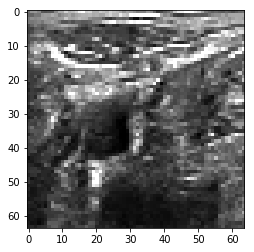

In [49]:
plt.imshow(ims_train[1].reshape(64,64),cmap='gist_gray')

In [10]:
ims_test = []
for i in test['image']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ims_test.append(a)
ims_test = np.array(ims_test)
ims_test = ims_test.reshape(-1, 64,64,1)
ims_test = ims_test/255
ims_test = np.array( ims_test, dtype=np.float32 ) 
ims_test.shape

ms_test = []
for i in test['mask']:
    a = Image.open('train_subset/' + i)
    a = a.resize((64,64))
    a=np.array(a)
    ms_test.append(a)
ms_test = np.array(ms_test)
ms_test = ms_test.reshape(-1, 64,64,1)
ms_test = ms_test/255
ms_test = np.array(ms_test, dtype=np.float32 ) 
ms_test.shape

(99, 64, 64, 1)

In [51]:
x = tf.placeholder(tf.float32,shape=[None,64,64,1])
y = tf.placeholder(tf.float32, shape=[None, 64,64, 1])

convo_1 = convolutional_layer(x,shape=[3,3,1,16])
convo_1_0_pooling = max_pool_2by2(convo_1)
dropout_0 = tf.nn.dropout(convo_1_0_pooling,keep_prob=hold_prob)

convo_1_2 = convolutional_layer(dropout_0,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

dropout_1 = tf.nn.dropout(convo_1_pooling,keep_prob=hold_prob)

convo_2 = convolutional_layer(dropout_1,shape=[3,3,16,32]) # images 16*16

dropout_2 = tf.nn.dropout(convo_2,keep_prob=hold_prob)

up_1 = upsample_concat(dropout_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
dropout_3 = tf.nn.dropout(convo_3_0,keep_prob=hold_prob)

up_2 = upsample_concat(dropout_3, convo_1) # image 32*32
convo_3 = convolutional_layer(up_2,shape=[3,3,32,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optim.minimize(loss)

In [52]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(2500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y, hold_prob:0.7})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test, hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
print('Final test loss: ', final_test_loss)

Minibatch loss at step 0: -0.022576
Currently on step 0
Test loss:
-0.0129803


Minibatch loss at step 50: -0.025104
Currently on step 50
Test loss:
-0.0271182


Minibatch loss at step 100: -0.052719
Currently on step 100
Test loss:
-0.0454669


Minibatch loss at step 150: -0.060174
Currently on step 150
Test loss:
-0.0835273


Minibatch loss at step 200: -0.065141
Currently on step 200
Test loss:
-0.0988145


Minibatch loss at step 250: -0.088507
Currently on step 250
Test loss:
-0.0960415


Minibatch loss at step 300: -0.092392
Currently on step 300
Test loss:
-0.0965311


Minibatch loss at step 350: -0.132392
Currently on step 350
Test loss:
-0.103752


Minibatch loss at step 400: -0.103047
Currently on step 400
Test loss:
-0.0971544


Minibatch loss at step 450: -0.116024
Currently on step 450
Test loss:
-0.101735


Minibatch loss at step 500: -0.098437
Currently on step 500
Test loss:
-0.122948


Minibatch loss at step 550: -0.123237
Currently on step 550
Test loss:
-0.125899


Mi

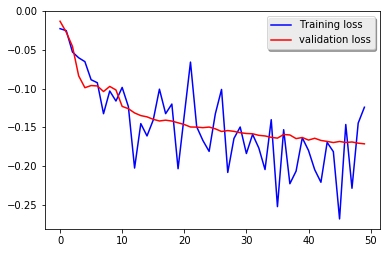

In [53]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

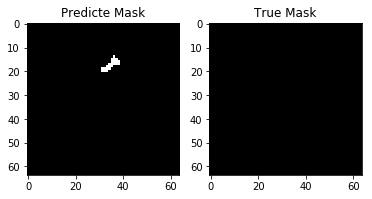

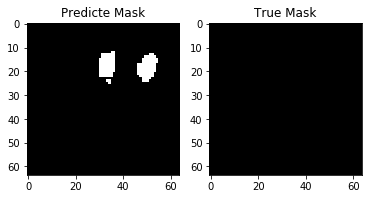

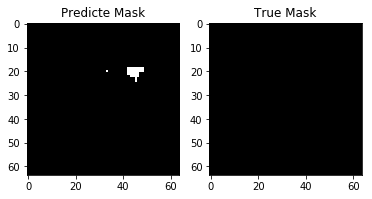

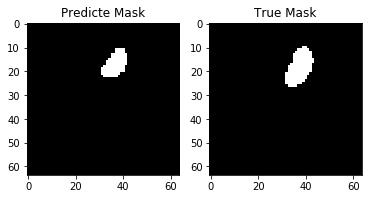

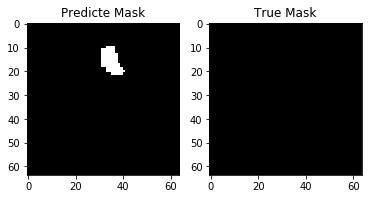

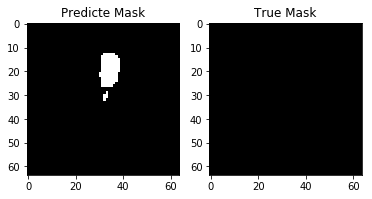

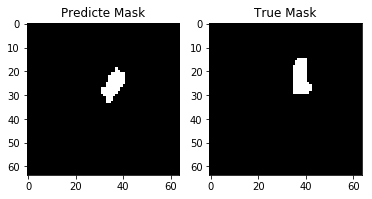

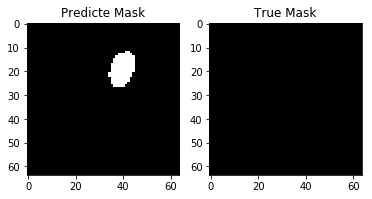

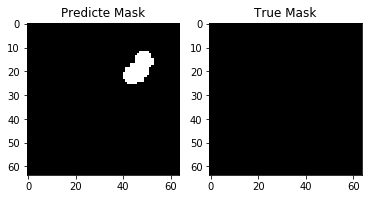

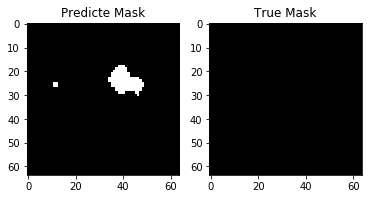

In [55]:
test_result = output >= 0.5  # predicted masks

for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(64,64),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(64,64),cmap='gist_gray')
    axes[1].set_title('True Mask')

# Now I am going to add two more convolutional layers.
Since we do not have overfitting in the previouse model, I decided to add more layers.

In [11]:
x = tf.placeholder(tf.float32,shape=[None,64,64,1])
y = tf.placeholder(tf.float32, shape=[None, 64,64, 1])

convo_0 = convolutional_layer(x,shape=[3,3,1,16])
convo_1 = convolutional_layer(convo_0,shape=[3,3,16,16])
convo_1_0_pooling = max_pool_2by2(convo_1)
dropout_0 = tf.nn.dropout(convo_1_0_pooling,keep_prob=hold_prob)

convo_1_2 = convolutional_layer(dropout_0,shape=[3,3,16,16])
convo_1_pooling = max_pool_2by2(convo_1_2)

dropout_1 = tf.nn.dropout(convo_1_pooling,keep_prob=hold_prob)

convo_2 = convolutional_layer(dropout_1,shape=[3,3,16,32]) # images 16*16

dropout_2 = tf.nn.dropout(convo_2,keep_prob=hold_prob)

up_1 = upsample_concat(dropout_2, convo_1_2) # image 32*32
convo_3_0 = convolutional_layer(up_1,shape=[3,3,48,16])
dropout_3 = tf.nn.dropout(convo_3_0,keep_prob=hold_prob)

up_2 = upsample_concat(dropout_3, convo_1) # image 32*32
convo_3 = convolutional_layer(up_2,shape=[3,3,32,16])
convo_4 = convolutional_layer(convo_3,shape=[3,3,16,16])

pred = tf.layers.conv2d(convo_3, 1, (1, 1), activation=tf.nn.sigmoid, padding='same')

loss = -dice_score(pred, y)
optim = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optim.minimize(loss)

In [12]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_test = []
for i in range(2500): # 8 batches for 1 epoch
        if i%8 == 0:
            ims_train, ms_train = shufled(ims_train, ms_train)
        offset = (i * 64) % ims_train.shape[0] # 64 is the batch size
        batch_x = ims_train[offset:(offset + 64), :]
        batch_y = ms_train[offset:(offset + 64), :]
        _, l, predictions = sess.run([train, loss, pred], feed_dict={x: batch_x, y: batch_y, hold_prob:0.7})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if i%50 == 0:
            loss_train.append(l)
            print("Minibatch loss at step %d: %f" % (i, l))
            print('Currently on step {}'.format(i))
            print('Test loss:')
            # Test the Train Model
            test_l = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
            print(test_l)
            print('\n')
            loss_test.append(test_l)
            
output= sess.run(pred,feed_dict={x: ims_test, hold_prob:1.0})
final_test_loss = sess.run(loss, feed_dict={x:ims_test,y:ms_test,hold_prob:1.0})
print('Final test loss: ', final_test_loss)

Minibatch loss at step 0: -0.017353
Currently on step 0
Test loss:
-0.0130742


Minibatch loss at step 50: -0.023989
Currently on step 50
Test loss:
-0.0289396


Minibatch loss at step 100: -0.057571
Currently on step 100
Test loss:
-0.0569451


Minibatch loss at step 150: -0.075933
Currently on step 150
Test loss:
-0.0818664


Minibatch loss at step 200: -0.089079
Currently on step 200
Test loss:
-0.101629


Minibatch loss at step 250: -0.121542
Currently on step 250
Test loss:
-0.109734


Minibatch loss at step 300: -0.154469
Currently on step 300
Test loss:
-0.119497


Minibatch loss at step 350: -0.159249
Currently on step 350
Test loss:
-0.118703


Minibatch loss at step 400: -0.152271
Currently on step 400
Test loss:
-0.123175


Minibatch loss at step 450: -0.147142
Currently on step 450
Test loss:
-0.130154


Minibatch loss at step 500: -0.164764
Currently on step 500
Test loss:
-0.133056


Minibatch loss at step 550: -0.134878
Currently on step 550
Test loss:
-0.136834


Miniba

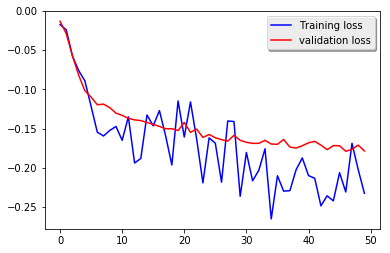

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, color='b', label="Training loss")
ax.plot(loss_test, color='r', label="validation loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

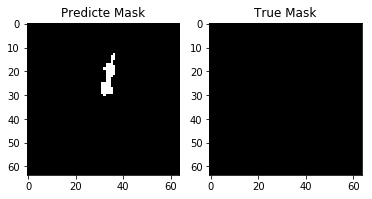

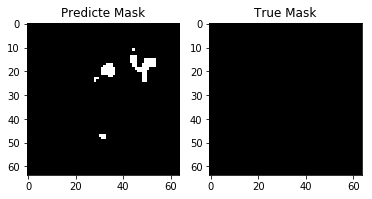

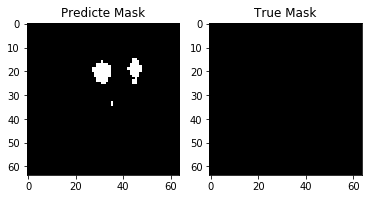

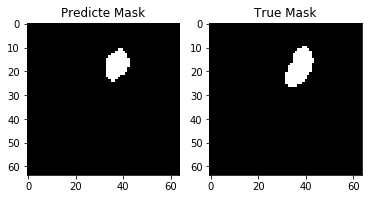

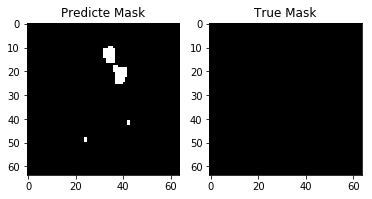

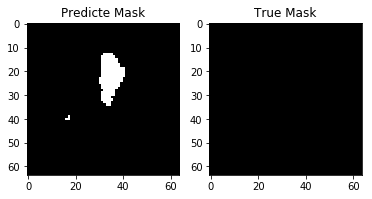

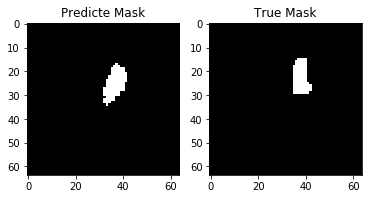

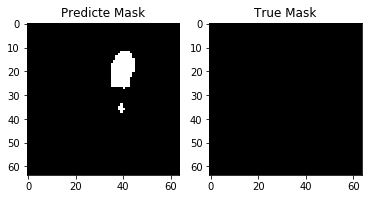

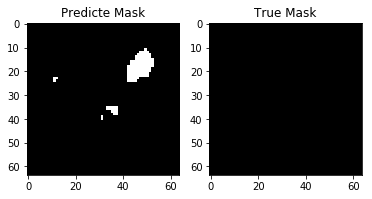

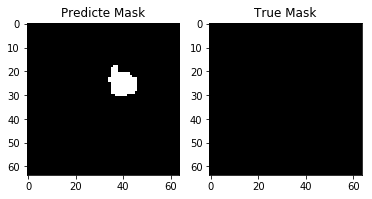

In [17]:
test_result = output >= 0.5  # predicted masks
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(test_result[i].reshape(64,64),cmap='gist_gray')
    axes[0].set_title('Predicte Mask')

    axes[1].imshow(ms_test[i].reshape(64,64),cmap='gist_gray')
    axes[1].set_title('True Mask')

### Number of network parameters used and the number of required Ops
### (multiplications + additions, for a batch of 1)

input is image (64,64,1)

|Layer            |layer architecture| mulitiplications | additions | together | paramerts
| ------------- | ------------- |--------------|-----------
| conv_0  | 16 filters with kernel of size (3,3,1)| 16 filters * 64 * 64 * 9 * 1 = 589824 | 589824 | 1179648 | 16 filters * 3 * 3 * 1 + 16 biases = 160
| conv_1 |  16 filters with kernel of size (3,3,16) |16 filters * 64 * 64 * 9 * 16 = 9437184 | 9437184 | 18874368 | 16 * 3 * 3 * 16 + 16 = 2320
| 2 by 2 max pooling | - | - | - |- | 0
| dropout | - | - | - | -| 0
| conv_1_2 |  16 filters with kernel of size (3,3,16) |16 filters * 32 * 32 * 9 * 16 = 2359296 | 2359296 | 4718592 | 16 * 3 * 3 * 16 + 16 = 2320
| 2 by 2 max pooling | - | - | - |- | 0
| dropout | - | - | - | -| 0
| conv_2 |  32 filters with kernel of size (3,3,16) |32 filters * 16 * 16 * 9 * 16 = 1179648 | 1179648 | 2359296 | 32 * 3 * 3 * 16 + 32 = 4640
| dropout | - | - | - | -| 0
| upsampling_1 |  resize to the nearest neighbor |- | - | - | -
| conv_3_0 |  16 filters with kernel of size (3,3,48) |16 filters * 32 * 32 * 9 * 48 = 7077888 | 7077888 | 14155776 | 16 * 3 * 3 * 48 + 16 = 6928
| dropout | - | - | - | -| 0
| upsampling_2 |  resize to the nearest neighbor |- | - | - | -
| conv_3 |  16 filters with kernel of size (3,3,32) |16 filters * 64 * 64 * 9 * 32 = 18874368 | 18874368 | 37748736 | 16 * 3 * 3 * 32 + 16 = 4624
| conv_4 |  16 filters with kernel of size (3,3,16) |16 filters * 64 * 64 * 9 * 16 = 9437184 | 9437184 | 18874368 | 16 * 3 * 3 * 16 + 16 = 2320




## Next steps
1. Increase the numbers of layers
2. Increase the size of images up to real size.
3. Increase the number of iterations (training time)
4. Try image augmentation (since we have very few data it could be helpful)